<a href="https://colab.research.google.com/github/fbeilstein/neural_networks/blob/master/lecture_3_nn_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LeNet

* Developed by Yann LeCun et al. in 1998.

* One of the first successful CNNs, applied to handwritten digit recognition (MNIST).

* Paved the way for modern deep learning in computer vision.

-----

* Uses tanh activation (ReLU was not yet popular).
* Uses average pooling, not max pooling (which became popular later).
* No Dropout or BatchNorm. These techniques didn't exist at the time. LeNet-5 is much shallower and simpler.

-----

* CNN structure idea: alternating convolution + pooling.

* Weight sharing: dramatically reduces number of parameters vs fully connected layers.

* Local receptive fields: how neurons look only at parts of the image.

* Low parameter count: around 60k parameters—tiny by modern standards!

* Bias-variance balance: good example of a simple model that avoids overfitting by design.

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/lenet_architecture.png" width='550'>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. LeNet-5 architecture
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # 28x28 -> 24x24
    self.pool1 = nn.AvgPool2d(kernel_size=2)      # 24x24 -> 12x12
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 12x12 -> 8x8
    self.pool2 = nn.AvgPool2d(kernel_size=2)      # 8x8 -> 4x4
    self.conv3 = nn.Conv2d(16, 120, kernel_size=4)  # 4x4 -> 1x1

    self.fc1 = nn.Linear(120, 84)
    self.fc2 = nn.Linear(84, 10)

  def forward(self, x):
    x = torch.tanh(self.conv1(x))
    x = self.pool1(x)
    x = torch.tanh(self.conv2(x))
    x = self.pool2(x)
    x = torch.tanh(self.conv3(x))
    x = x.view(-1, 120)
    x = torch.tanh(self.fc1(x))
    x = self.fc2(x)
    return x


In [ ]:
# 2. Prepare data
transform = transforms.Compose([
  transforms.Resize((28, 28)),  # Just to be sure
  transforms.ToTensor()
])

train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root='data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000, shuffle=False)

# 3. Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop
for epoch in range(5):
  model.train()
  total_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.08MB/s]


Epoch 1, Loss: 294.13
Epoch 2, Loss: 96.04
Epoch 3, Loss: 66.10
Epoch 4, Loss: 50.09
Epoch 5, Loss: 40.33


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.45%


#AlexNet

* Breakthrough: AlexNet won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012 by a huge margin.

* Popularized CNNs: It showed that convolutional neural networks trained on GPUs could achieve state-of-the-art results on real-world large-scale datasets.

* Catalyst for Deep Learning: It essentially started the current deep learning boom in computer vision.

--------

**New Features/Ideas**

* Deep Architecture
* ReLU Activation	instead of tanh/sigmoid for faster convergence
* Introduced dropout to prevent overfitting in fully connected layers
* Used overlapping $3\times 3$ pooling (stride 2) instead of $2 \times 2$ non-overlapping
* Used data augmentation techniques like image translation and reflection to expand dataset
* Trained on 2 GPUs, splitting the model across them (early model parallelism)
* Used Local Response Normalization (LRN) to encourage lateral inhibition (now less common)

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/alexnet_architecture.png" width='550'>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# Define AlexNet for CIFAR-10 (input 3x32x32 instead of 224x224)
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # CIFAR-10: input 32x32, here causes strong shrink
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(96, 256, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(256, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.LazyLinear(4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


In [ ]:
# Transforms
#transform = transforms.Compose([
#  transforms.Resize(32),  # Resize if needed
#  transforms.ToTensor(),
#  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#])

transform = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),
])

# Download CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=100, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # keep small on Colab
  model.train()
  running_loss = 0.0
  for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

In [ ]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


#Autoencoder

In [ ]:
#@title Manual PCA
%%html
<iframe title="Demo"
        src="https://fbeilstein.github.io/machine_learning/lecture_12_principal_component_analysis/demo_pca.html"
        width="800" height="450"
        marginwidth="0" marginheight="0" frameborder="0"
        scrolling="no">
Your browser does not support IFrames.
</iframe>


In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/autoencoder_architecture.webp" height=400>


**Autoencoder**

* Neural network trained to reconstruct input from a compressed internal representation.
* Consists of:
  - Encoder: Maps input → latent space.
  - Decoder: Reconstructs input from latent code.
* Unsupervised learning: No labels needed during training.

--------

**Architecture**
* Symmetric structure: Encoder and decoder mirror each other.
* Common layers: Fully connected (dense), Convolutional (for images)
* Bottleneck layer: Represents compressed features.

-------

**Applications**
* Dimensionality reduction (alternative to PCA)
* Denoising: Removes noise from corrupted input
* Anomaly detection: Poor reconstruction signals anomaly
* Image compression and synthesis

**Denoising Autoencoders**
* Trained with noisy input but clean target.
* Learns to map noisy → clean data.
* Helps the model extract robust features.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16x14x14
      nn.ReLU(),
      nn.Conv2d(16, 4, 3, stride=2, padding=1),  # 4x7x7
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(4, 16, 3, stride=2, output_padding=1, padding=1),  # 16x14x14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  # 1x28x28
        nn.Sigmoid()
      )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

In [ ]:
class NoisyMNIST(Dataset):
  def __init__(self, train=True):
    self.data = datasets.MNIST(root='./data', train=train, download=True,
                                transform=transforms.ToTensor())

  def __getitem__(self, index):
    img, label = self.data[index]
    noisy_img = img + 0.5 * torch.randn_like(img)  # add Gaussian noise
    noisy_img = torch.clip(noisy_img, 0., 1.)
    return noisy_img, img

  def __len__(self):
    return len(self.data)


train_loader = DataLoader(NoisyMNIST(train=True), batch_size=128, shuffle=True)
test_loader = DataLoader(NoisyMNIST(train=False), batch_size=10, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.24MB/s]


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
  model.train()
  loss_sum = 0
  for noisy, clean in train_loader:
    noisy, clean = noisy.to(device), clean.to(device)
    output = model(noisy)
    loss = criterion(output, clean)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_sum += loss.item()
  print(f"Epoch {epoch+1}, Loss: {loss_sum / len(train_loader):.4f}")


Epoch 1, Loss: 0.0595
Epoch 2, Loss: 0.0190
Epoch 3, Loss: 0.0177
Epoch 4, Loss: 0.0171
Epoch 5, Loss: 0.0164


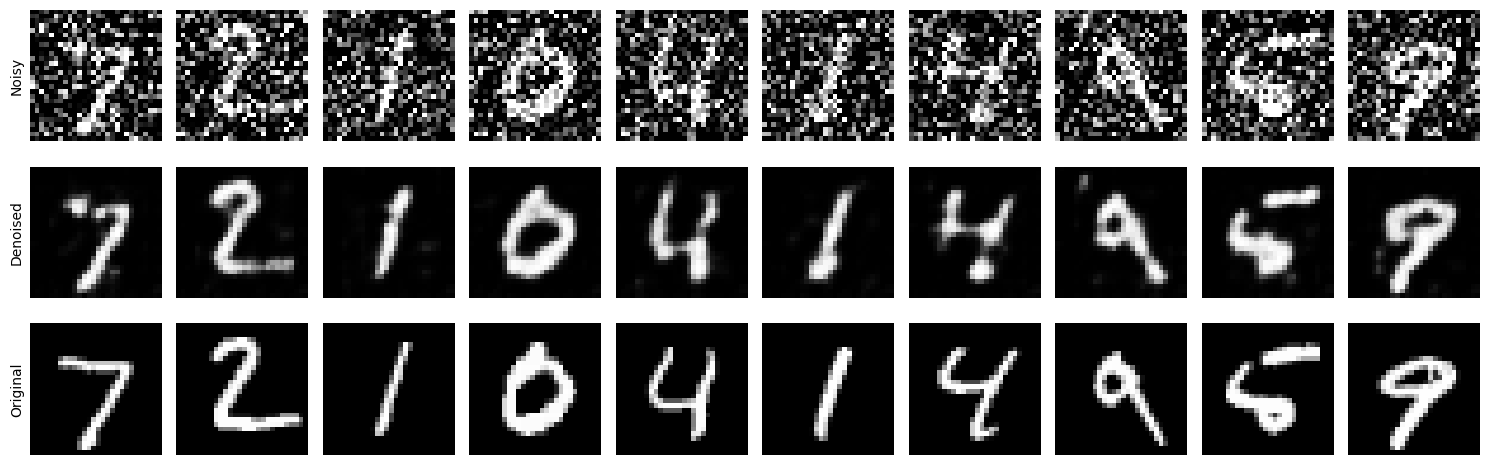

In [ ]:
model.eval()
noisy_imgs, clean_imgs = next(iter(test_loader))
with torch.no_grad():
  noisy_imgs = noisy_imgs.to(device)
  reconstructed = model(noisy_imgs).cpu()

# Plotting
def show_images(noisy, reconstructed, original):
  fig, axs = plt.subplots(3, 10, figsize=(15, 5))
  for i in range(10):
    axs[0, i].imshow(noisy[i][0], cmap='gray')
    axs[1, i].imshow(reconstructed[i][0], cmap='gray')
    axs[2, i].imshow(original[i][0], cmap='gray')
    for ax in axs[:, i]:
      #ax.axis('off')
      ax.spines[:].set_visible(False)
      ax.set_xticks([])
      ax.set_yticks([])
  axs[0, 0].set_ylabel("Noisy")
  axs[1, 0].set_ylabel("Denoised")
  axs[2, 0].set_ylabel("Original")
  plt.tight_layout()
  plt.show()

show_images(noisy_imgs.cpu(), reconstructed, clean_imgs)


#Variational Autoencoder (VAE)

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/VAE1.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/VAE2.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/VAE3.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/VAE4.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/VAE5.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/VAE6.webp" width=750>
`])

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


Epoch 1, Loss: 163.97
Epoch 2, Loss: 121.15
Epoch 3, Loss: 114.52
Epoch 4, Loss: 111.60
Epoch 5, Loss: 109.86
Epoch 6, Loss: 108.63
Epoch 7, Loss: 107.83
Epoch 8, Loss: 107.15
Epoch 9, Loss: 106.65
Epoch 10, Loss: 106.19


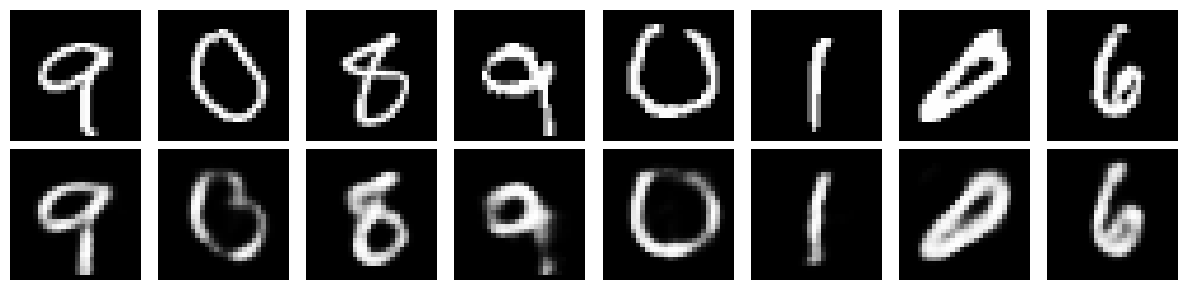

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.ToTensor()

train_data = datasets.MNIST(root="data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

class VAE(nn.Module):
  def __init__(self, latent_dim=20):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 400),
      nn.ReLU(),
    )
    self.fc_mu = nn.Linear(400, latent_dim)
    self.fc_logvar = nn.Linear(400, latent_dim)

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 400),
      nn.ReLU(),
      nn.Linear(400, 28*28),
      nn.Sigmoid()  # output in [0,1]
    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std  # reparameterization trick

  def forward(self, x):
    x = self.encoder(x)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    z = self.reparameterize(mu, logvar)
    recon = self.decoder(z)
    return recon.view(-1, 1, 28, 28), mu, logvar

def loss_function(recon_x, x, mu, logvar):
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kl_div

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 11):
  model.train()
  total_loss = 0
  for x, _ in train_loader:
    x = x.to(device)
    recon_x, mu, logvar = model(x)
    loss = loss_function(recon_x, x, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader.dataset):.2f}")

model.eval()
with torch.no_grad():
  x, _ = next(iter(train_loader))
  x = x.to(device)
  recon_x, _, _ = model(x)

  fig, axs = plt.subplots(2, 8, figsize=(12, 3))
  for i in range(8):
    axs[0, i].imshow(x[i].cpu().squeeze(), cmap="gray")
    axs[1, i].imshow(recon_x[i].cpu().squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].axis("off")
  axs[0, 0].set_ylabel("Input")
  axs[1, 0].set_ylabel("Recon")
  plt.tight_layout()
  plt.show()


#ResNet

In [7]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/Resnet18_architecture.svg" width=750>


In [1]:
# ResNet (ResNet18-like) for MNIST classification

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                            stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1,
                  stride=stride, bias=False),
        nn.BatchNorm2d(out_channels))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    return F.relu(out)

class ResNetSmall(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.init_conv = nn.Sequential(
      nn.Conv2d(1, 16, 3, 1, 1),
      nn.BatchNorm2d(16),
      nn.ReLU())

    self.layer1 = BasicBlock(16, 32, stride=2)
    self.layer2 = BasicBlock(32, 64, stride=2)
    self.layer3 = BasicBlock(64, 128, stride=2)

    self.pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.init_conv(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return self.fc(x)

In [3]:
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform for MNIST
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset and dataloader
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

# Instantiate model, loss, optimizer
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Keep it short for demo
  model.train()
  running_loss = 0.0
  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]


Epoch 1, Loss: 0.1276
Epoch 2, Loss: 0.0361
Epoch 3, Loss: 0.0262
Epoch 4, Loss: 0.0190
Epoch 5, Loss: 0.0183
Accuracy on test set: 99.16%


#U-Net

![img](https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/unet_architecture.png)

In [11]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/unet_architecture.png" width=750>


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


# --- U-Net Mini Model ---

class UNetSmall(nn.Module):
  def __init__(self):
    super().__init__()
    self.enc1 = self.conv_block(1, 32)
    self.enc2 = self.conv_block(32, 64)
    self.enc3 = self.conv_block(64, 128)

    self.pool = nn.MaxPool2d(2)

    self.middle = self.conv_block(128, 256)

    self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
    self.dec2 = self.conv_block(256, 128)

    self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
    self.dec1 = self.conv_block(128, 64)

    self.up0 = nn.ConvTranspose2d(64, 32, 2, stride=2)
    self.dec0 = self.conv_block(64, 32)

    self.out = nn.Conv2d(32, 1, 1)

  def conv_block(self, in_c, out_c):
    return nn.Sequential(
      nn.Conv2d(in_c, out_c, 3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_c, out_c, 3, padding=1),
      nn.ReLU(),
    )

  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(self.pool(e1))
    e3 = self.enc3(self.pool(e2))

    m = self.middle(self.pool(e3))

    d2 = self.dec2(torch.cat([self.up2(m), e3], dim=1))
    d1 = self.dec1(torch.cat([self.up1(d2), e2], dim=1))
    d0 = self.dec0(torch.cat([self.up0(d1), e1], dim=1))

    return torch.sigmoid(self.out(d0))



Epoch 1, Loss: 0.0127
Epoch 2, Loss: 0.0017
Epoch 3, Loss: 0.0011


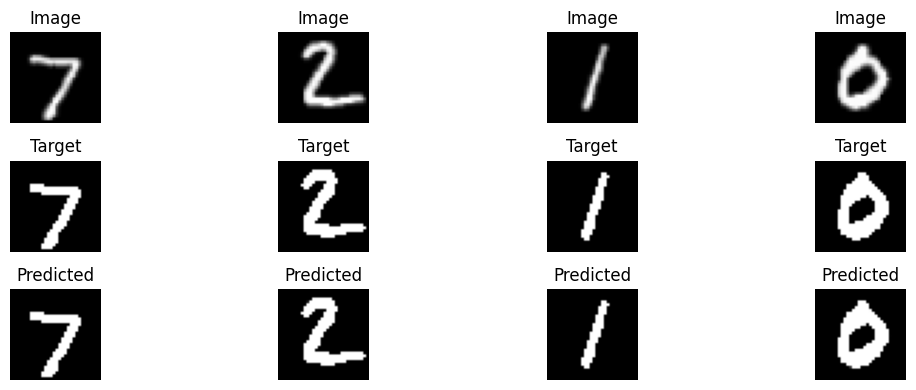

In [10]:
# --- Dummy Segmentation Dataset ---

class MNISTSegmentation(Dataset):
  def __init__(self, mnist_dataset):
    self.mnist = mnist_dataset

  def __len__(self):
    return len(self.mnist)

  def __getitem__(self, idx):
    img, label = self.mnist[idx]
    mask = (img > 0.2).float()  # crude foreground mask
    return img, mask

# --- Training UNet on synthetic masks ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((32, 32)), # need this for good sizes
    transforms.ToTensor()
])

mnist_train = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainset_seg = MNISTSegmentation(mnist_train)
testset_seg = MNISTSegmentation(mnist_test)

trainloader_seg = DataLoader(trainset_seg, batch_size=32, shuffle=True)
testloader_seg = DataLoader(testset_seg, batch_size=32, shuffle=False)

model = UNetSmall().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(3):  # Short training for demo
  model.train()
  total_loss = 0
  for img, mask in trainloader_seg:
    img, mask = img.to(device), mask.to(device)
    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, mask)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch+1}, Loss: {total_loss / len(trainloader_seg):.4f}")

# Show some predictions
model.eval()
with torch.no_grad():
  img, mask = next(iter(testloader_seg))
  img = img.to(device)
  pred = model(img)

img = img.cpu().numpy()
pred = pred.cpu().numpy()
mask = mask.numpy()

plt.figure(figsize=(12, 4))
for i in range(4):
  plt.subplot(3, 4, i+1)
  plt.imshow(img[i, 0], cmap='gray')
  plt.axis('off')
  plt.title("Image")

  plt.subplot(3, 4, i+5)
  plt.imshow(mask[i, 0], cmap='gray')
  plt.axis('off')
  plt.title("Target")

  plt.subplot(3, 4, i+9)
  plt.imshow(pred[i, 0], cmap='gray')
  plt.axis('off')
  plt.title("Predicted")

plt.tight_layout()
plt.show()


#VGG-16

![img](https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/vgg16_architecture.png)

#FCN-32

![img](https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/fcn32_architecture.png)

#GAN

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/GAN1.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/GAN2.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_3_nn_architectures/GAN3.webp" width=750>
`])

for details see "*Generative Adversarial Nets*" by Ian J. Goodfellow et all.


**for** number of training iterations **do**

$~~~~$**for** $k$ steps **do**

$~~~~$$~~~~$• Sample minibatch of $m$ noise samples $\{z^{(1)},\dots,z^{(m)}\}$ from noise prior $p_g(z)$.

$~~~~$$~~~~$• Sample minibatch of $m$ examples $\{x^{(1)},\dots,x^{(m)}\}$ from data generating distribution $p_\text{data}(x)$.

$~~~~$$~~~~$• Update the discriminator by ascending its stochastic gradient:
$$
\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^m \left[ \ln D (x^{(i)}) + \ln \left( 1 - D(G(z^{(i)})) \right)\right]
$$
$~~~~$**end for**

$~~~~$• Sample minibatch of $m$ noise samples $\{z^{(1)},\dots,z^{(m)}\}$ from noise prior $p_g(z)$.

$~~~~$• Update the generator by descending its stochastic gradient:
$$
\nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m \ln \left( 1 - D(G(z^{(i)})) \right)
$$

**end for**

$D$ - probability that data is genuine.

For perfect discriminator $D(x) = 1$ and $D(G(z)) = 0$. In this case $\ln D + \ln(1-D(G)) = 0$ while for any other case $< 0$. **Discriminator maximizes loss**.

$G$ - would be perfect if $D(G) = 1$, thus loss would be $-\infty$. **Generator minimizes loss**

$$
\min_G \max_D \frac{1}{m} \sum_{i=1}^m \left[ \ln D (x^{(i)}) + \ln \left( 1 - D(G(z^{(i)})) \right)\right]
$$

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Inter-house_sports-_tug_of_war.jpg/640px-Inter-house_sports-_tug_of_war.jpg)

It can be proven that balance is acieved when $D(x) = D(G(z)) = 1/2$, that basically means genuine and generated data are indistinguishable.